In [59]:
from datetime import datetime
import warnings
from agents.evn_mvo import StockPortfolioEnv
from agents.mvo_agent import MarkowitzAgent
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
%matplotlib inline
from finrl.meta.preprocessor.preprocessors import data_split
from finrl.agents.stablebaselines3.models import DRLAgent
from feature_engineer import FeatureEngineer
from models import DRLAgent
from portfolio_optimization_env import PortfolioOptimizationEnv
import sys
import scienceplots
sys.path.append("../FinRL-Library")
plt.style.use('science')

from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
)
from pypfopt import expected_returns

check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

def DRL_prediction(model, environment,time_window, deterministic=True):
    """make a prediction and get results"""
    test_env, test_obs = environment.get_sb_env()
    account_memory = None  # This help avoid unnecessary list creation
    actions_memory = None  # optimize memory consumption
    # state_memory=[] #add memory pool to store states

    test_env.reset()
    max_steps = len(environment._df.index.unique()) - (time_window) - 1

    for i in range(len(environment._df.index.unique())):
        action, _states = model.predict(test_obs, deterministic=deterministic)
        test_obs, rewards, dones, info = test_env.step(action)
        if i == max_steps:  
            date_list = environment._date_memory
            portfolio_return = environment._portfolio_return_memory
            df_account_value = pd.DataFrame(
                {"date": date_list, "daily_return": portfolio_return,'account' :  environment._asset_memory["final"],'weights':environment._final_weights}
            )
            df_date = pd.DataFrame(date_list)
            df_date.columns = ["date"]

            action_list = environment._actions_memory
            df_actions = pd.DataFrame(action_list)
            tiks = environment._tic_list
            df_actions.index = df_date.date
            account_memory = df_account_value
            actions_memory = df_actions

        if dones[0]:
            print("hit end!")
            break
    return account_memory, actions_memory
TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE = '2020-12-31'
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2024-12-31'
from pandas import read_csv
from stable_baselines3.common.callbacks import CheckpointCallback

df_dow =read_csv('./data/dow.csv')
df_nasdaq =read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')
def mvo_data(data, INDICATORS, TEST_START_DATE, TEST_END_DATE):
    final_result = []
    df = data.sort_values(['date', 'tic'], ignore_index=True).copy()
    df.index = df.date.factorize()[0]
    cov_list = []
    mu = []
    # look back is one year
    lookback = 252
    for i in range(lookback, len(df.index.unique())):
        data_lookback = df.loc[i-lookback:i, :]
        price_lookback = data_lookback.pivot_table(
            index='date', columns='tic', values='close')
        return_lookback = price_lookback.pct_change().dropna()
        covs = return_lookback.cov().values
        mu.append(expected_returns.mean_historical_return(price_lookback))
        cov_list.append(covs)
    df_cov = pd.DataFrame(
        {'time': df.date.unique()[lookback:], 'cov_list': cov_list, 'returns': mu})
    df = df.merge(df_cov, left_on='date', right_on='time')

    test_df = data_split(
        df,
        start=TEST_START_DATE,
        end=TEST_END_DATE
    )
    return test_df
def mvo(data, solver='OSQP',window=1, rf=0.02, pct=0.001,objective='min_variance'):
    result = {}
    stock_dimension = len(data.tic.unique())
    state_space = stock_dimension
    env_kwargs = {
        "hmax": 100,
        "initial_amount": 50_000,
        "transaction_cost_pct": pct,
        "state_space": state_space,
        "stock_dim": stock_dimension,
        "tech_indicator_list": INDICATORS,
        "action_space": stock_dimension,
        "reward_scaling": 1e-4,
        "window":window

    }
    e_test_gym = StockPortfolioEnv(df=data, **env_kwargs)
    agent = MarkowitzAgent(e_test_gym, rf=rf,objective=objective,cost=pct)
    mvo_min_variance = agent.prediction(e_test_gym)
    mvo_min_variance["method"] = "markowitz"
    mvo_min_variance.columns = ['date', 'account', 'return', 'method']
    result["test"] = mvo_min_variance
    result["name"] = 'Min Variance Portfolio'
    return result
def train_model(train_data,test_data,transaction_fee=0.001,use_sharpe=False,use_dsr=False,use_sortino=False,model_name='a2c'
                ,iterations = 100_000,save=True,load=False,tag='tag',features=["close","log_return"],t=5,args=None,indicators =None,starting_capital = 50_000,model_path=None,
                comission_fee_model =None ):
    env_kwargs = {
        "initial_amount": starting_capital, 
        "normalize_df":None,
        "features" :features,
        'comission_fee_pct':transaction_fee,
        'time_window':t,
        'comission_fee_model':comission_fee_model,
        'use_sharpe':use_sharpe,
        'use_sortino':use_sortino,
        'use_differentail_sharpe_ratio':use_dsr,
        
    }
    train_environment = PortfolioOptimizationEnv(df = train_data, **env_kwargs)
    train_environment._seed(142)
    env_kwargs = {
        "initial_amount": starting_capital, 
        "normalize_df":None,
        'comission_fee_pct':transaction_fee,
        "features" :features,
        'time_window':t,
        'use_sharpe':use_sharpe,
        'use_sortino':use_sortino,
        'use_differentail_sharpe_ratio':use_dsr,
    }

    test_environment = PortfolioOptimizationEnv(df = test_data, **env_kwargs)
    test_environment._seed(142)
    agent = DRLAgent(env = train_environment)
    model_agent = agent.get_model(model_name,
                                  tensorboard_log = './tensorboard_log_indicators_'+str(len(indicators))+'_tics_'str(len(train_data.tic.unique()))+'_'+'.'.join(features)+'/',
                                  model_kwargs = args)

    checkpoint_callback = CheckpointCallback(save_freq=10000,
                                             save_path='./history/'+str(len(indicators))+'_tics_'+str(len(train_data.tic.unique()))+'_'+'.'.join(features)+'/'+'_'+tag,
                                                 name_prefix=model_name)
    if not load:
        model = agent.train_model(model=model_agent, 
                                    tb_log_name=model_name,
                                    total_timesteps=iterations,checkpoint_callback=checkpoint_callback)
    else:
        print('loading model')
        if model_path == None:
            model = model_agent.load('./data/trained_models_2025/'+str(model_name)+'_'+str(iterations)+'_' + tag,env =train_environment)
        else:
            model = model_agent.load(model_path,env =train_environment)
    if save and not load:
        model.save('./data/trained_models/'+str(model_name)+'_'+str(iterations)+'_' + tag )
    metrics_df_dax = pd.DataFrame(
        {
            "date": train_environment._date_memory,
            "actions": train_environment._actions_memory,
            "weights": train_environment._final_weights,
            "returns": train_environment._portfolio_return_memory,
            "rewards": train_environment._portfolio_reward_memory,
            "portfolio_values": train_environment._asset_memory["final"],
        }
    )
    ppo_predictions = DRL_prediction(model, test_environment,t)
    results = {'train': metrics_df_dax,'test':ppo_predictions, 'model': model_agent}
    return results

In [62]:
xs = ['1', '2', '3']
s = '.'.join(xs)
s

'1.2.3'

In [9]:
import yahoo_fin.stock_info as si
import yfinance as yf
import time

ticks = si.tickers_ftse100(True)

dow = si.tickers_dow(True)
nifty = si.tickers_nifty50(True)

tickers = dow['Symbol'].values
def get_marketcaps(tickers):
    # List of stock tickers in the index

    # Initialize total market cap
    total_market_cap = 0
    market_caps = []
    # Loop through each stock ticker
    for ticker in tickers:
        # Fetch stock data
        stock = yf.Ticker(ticker)
        stock_info = stock.info
        market_cap = stock_info.get("marketCap")
        time.sleep(2)  
        if market_cap:
            market_caps.append(dict({'Symbol':ticker,'market_cap':market_cap}))
            total_market_cap += market_cap
        else:
            print(f"Market cap data not available for {ticker}")

    # Print the total market cap of the index
    print(f"\nTotal Market Cap of Index: ${total_market_cap:,}")
    marketcaps= pd.DataFrame(market_caps)
    merged_df = pd.merge(dow, marketcaps, on="Symbol", how="inner")
    indexes = merged_df.groupby('Industry')['market_cap'].idxmax()
    result = merged_df.loc[indexes]
    return result

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [ ]:
dow_indexes = get_marketcaps(tickers)
dow_indexes

In [ ]:
from finrl.config_tickers import DOW_30_TICKER,NAS_100_TICKER,HSI_50_TICKER,DAX_30_TICKER,SP_500_TICKER
sp500_indexes = get_marketcaps(SP_500_TICKER)


In [ ]:
sp500_indexes

In [17]:
sp500_indexes

,Company,Exchange,Symbol,Industry,Date added,Notes,Index weighting,market_cap
5,Boeing,NYSE,BA,Aerospace and defense,1987-03-12,NaN,2.15%,127115100160
2,Amgen,NASDAQ,AMGN,Biopharmaceutical,2020-08-31,NaN,3.76%,140414369792
10,Disney,NYSE,DIS,Broadcasting and entertainment,1991-05-06,NaN,1.60%,201304096768
20,Nike,NYSE,NKE,Clothing industry,2013-09-23,NaN,1.08%,109121929216
13,Honeywell,NASDAQ,HON,Conglomerate,2020-08-31,AlliedSignal and Honeywell,3.10%,147293945856
6,Caterpillar,NYSE,CAT,Construction and mining,1991-05-06,NaN,5.41%,175638544384
9,Coca-Cola,NYSE,KO,Drink industry,1987-03-12,Also 1932-05-26 to 1935-11-20,0.86%,266006659072
22,Procter & Gamble,NYSE,PG,Fast-moving consumer goods,1932-05-26,NaN,2.41%,388887773184
16,JPMorgan Chase,NYSE,JPM,Financial services,1991-05-06,NaN,3.36%,684915949568
17,McDonald's,NYSE,MCD,Food industry,1985-10-30,NaN,4.10%,211245252608


# DOW

In [38]:
# df =  df_dow[df_dow.tic.isin(['CSCO','AAPL','CAT','BA'])]
df =  df_dow.copy()

In [40]:
INDICATORS = [
    "close_5_ema",
    "close_21_ema",
    "close_62_ema",
]
fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list = INDICATORS,
                     use_turbulence=False,
                     user_defined_feature = True)

processed_dax = fe.preprocess_data(df[df["date"] > TRAIN_START_DATE])
data = processed_dax.copy()
data = data.fillna(0)
data = data.replace(np.inf,0)
train_data = data_split(data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(data, TEST_START_DATE, TEST_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 29, State Space: 146


In [18]:
covs= mvo_data(processed_dax,INDICATORS,TEST_START_DATE,TEST_END_DATE)


In [46]:
min_variance_portfolio = mvo(covs,pct=0)
max_sharpe_portfolio = mvo(covs,objective='sharpe',pct=0,rf=0)


begin_total_asset:50000
end_total_asset:64644.14045713236
Sharpe:  0.5976344114641189
Test Finished!
episode_return 1.2928828091426472
begin_total_asset:50000
end_total_asset:60540.00877666292
Sharpe:  0.38274829128545473
Test Finished!
episode_return 1.2108001755332585


In [50]:
stock_dimension = len(test_data.tic.unique())

environment_train_buy_and_hold = PortfolioOptimizationEnv(
    test_data,
    initial_amount=50_000,
    comission_fee_pct=0,
    time_window=5,
    features = ["close","return"],
    normalize_df=None
)
terminated = False

environment_train_buy_and_hold.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated, _ = environment_train_buy_and_hold.step(
        np.array(action, dtype=np.float32))

Episode:1
Initial portfolio value:50000
Final portfolio value: 70136.7265625
Final accumulative portfolio value: 1.40273453125


In [56]:
iterations = 500_000
result_ppo = train_model(train_data,test_data,transaction_fee=0,iterations=iterations,model_name='ppo',tag='dow30_indicator',args=  {
        "n_steps": 2048,
        "ent_coef": 0.01,
        "learning_rate": 0.0003,
        "batch_size": 256,
    },features=["close","log_return","close_21_ema"],comission_fee_model=None
    ,model_path='./history/2025-01-06_dow30_indicator/ppo_150000_steps',load=True
    )
# result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',save=True,tag='dow30')

{'n_steps': 2048, 'ent_coef': 0.01, 'learning_rate': 0.0003, 'batch_size': 256}
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
loading model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Episode:1
Initial portfolio value:50000
Final portfolio value: 71629.3828125
Final accumulative portfolio value: 1.43258765625
hit end!


In [ ]:
result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',tag='dow30_29_ddpg')

In [ ]:
result_ddpg = train_model(train_data,test_data,transaction_fee=0
                          ,model_path='./history/2025-01-06_dow30_ddpg_indiocators/ddpg_100000_steps',load=True
                          ,iterations=iterations,model_name='ddpg',tag='dow30_ddpg_indiocators'
                          ,features=["close","log_return","close_21_ema"])

In [ ]:
iterations = 500_000
result_ppo = train_model(train_data,test_data,load=True,iterations=iterations,model_name='ppo',tag='dow30',args=  {
        "n_steps": 2048,
        "ent_coef": 0.01,
        "learning_rate": 0.0003,
        "batch_size": 256,
    }, model_path='./history/2025-01-06_dow30_29/ppo_160000_steps',transaction_fee = 0
)
# result_ddpg = train_model(train_data,test_data,transaction_fee=0.001,iterations=iterations,model_name='ddpg',save=True,tag='dow30')

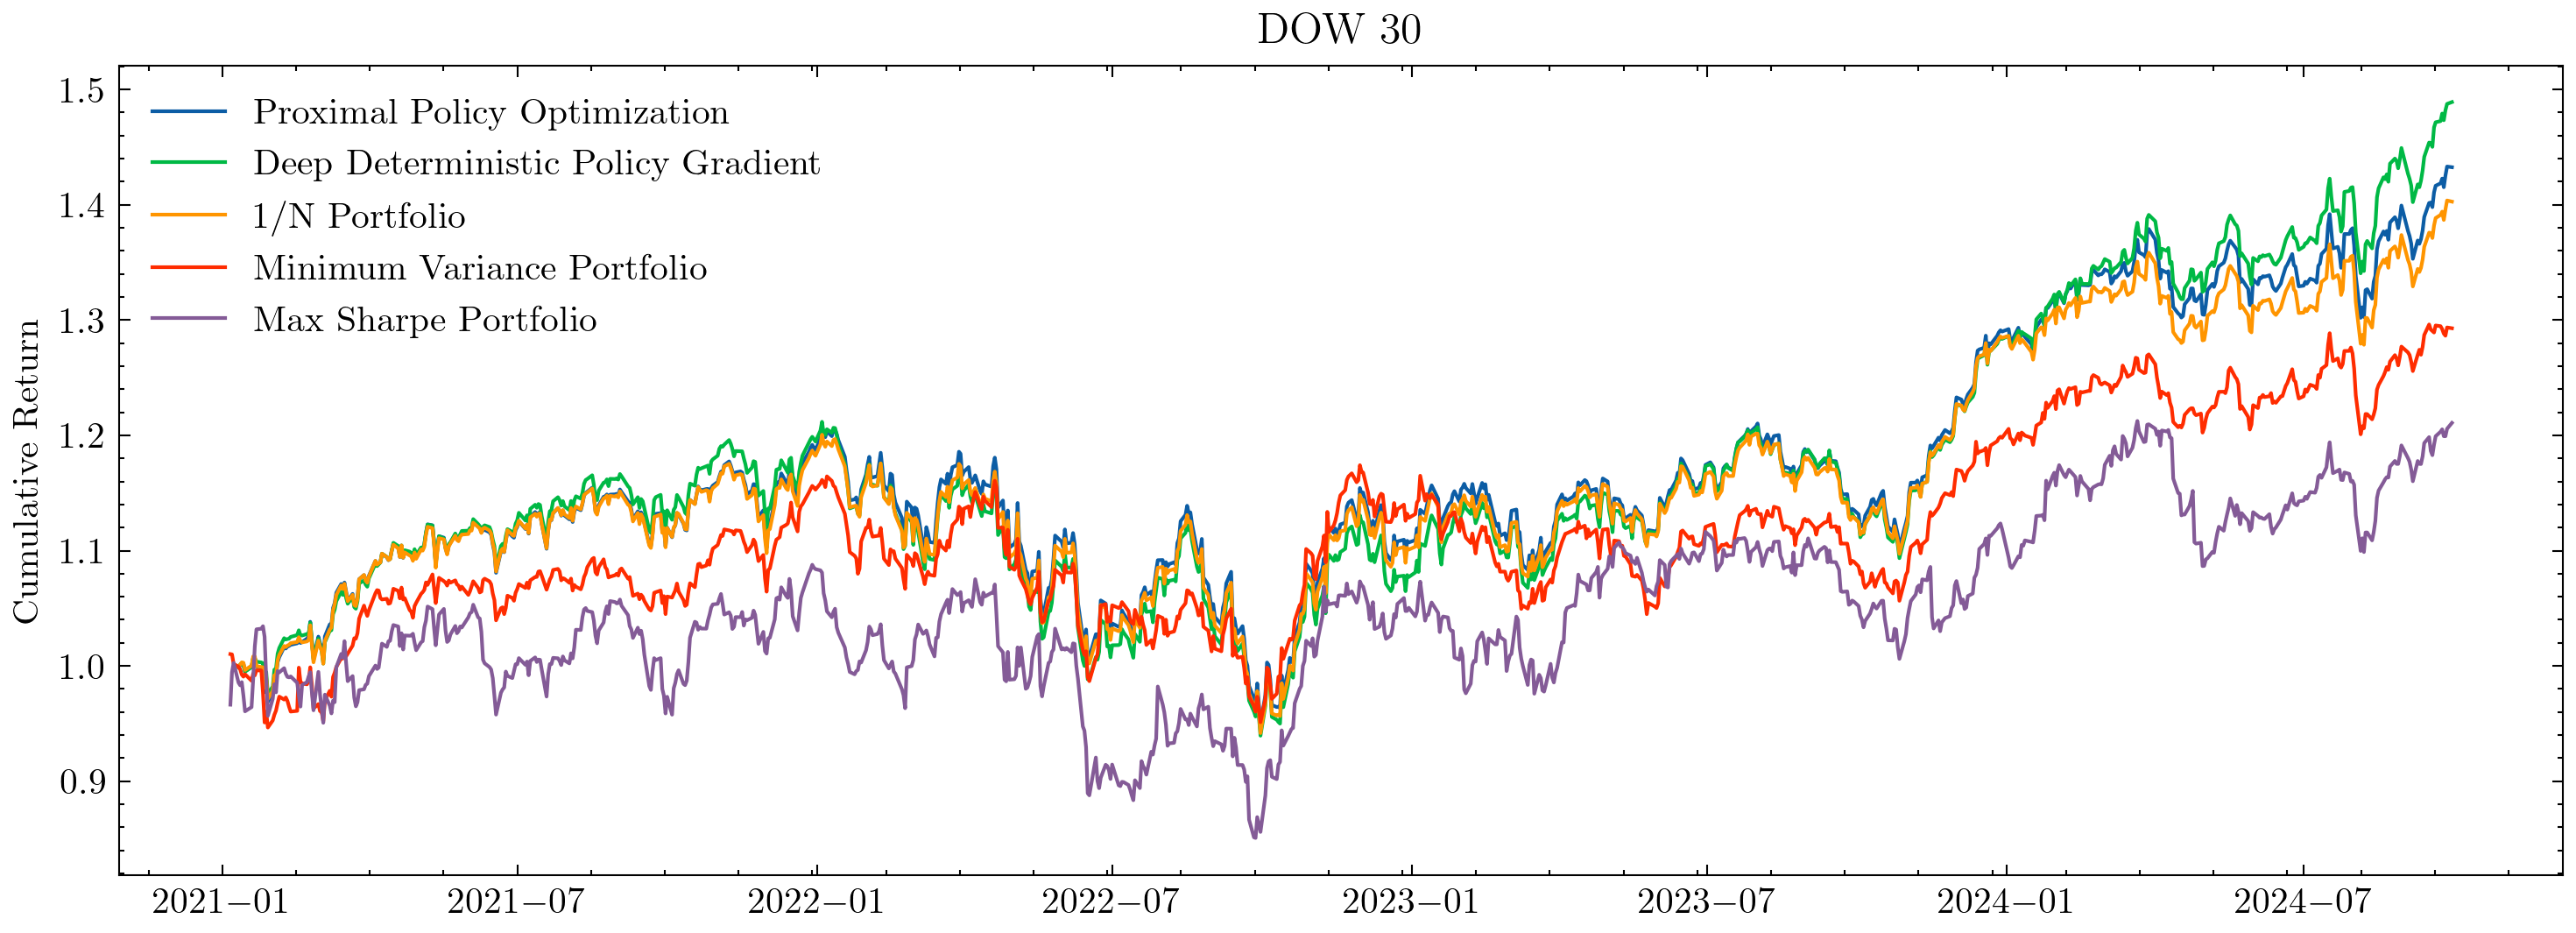

In [58]:
with plt.style.context('science','ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(result_ppo['test'][0].get('date'),(result_ppo['test'][0]['account'].pct_change() + 1).cumprod(),label='Proximal Policy Optimization')
    plt.plot(result_ddpg['test'][0].get('date'),(result_ddpg['test'][0]['account'].pct_change() + 1).cumprod(),label='Deep Deterministic Policy Gradient')
    plt.plot(environment_train_buy_and_hold._date_memory,(pd.Series(environment_train_buy_and_hold._asset_memory["final"]).pct_change() + 1).cumprod(),label = '1/N Portfolio')
    plt.plot(min_variance_portfolio['test'].date,( 1 +min_variance_portfolio['test'].account.pct_change()).cumprod(),label = 'Minimum Variance Portfolio')
    plt.plot(max_sharpe_portfolio['test'].date,( 1 +max_sharpe_portfolio['test'].account.pct_change()).cumprod(),label = 'Max Sharpe Portfolio')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.title('DOW 30')

max drowdown: -0.3144265218572365 Sharp ratio: 0.6044353238170149


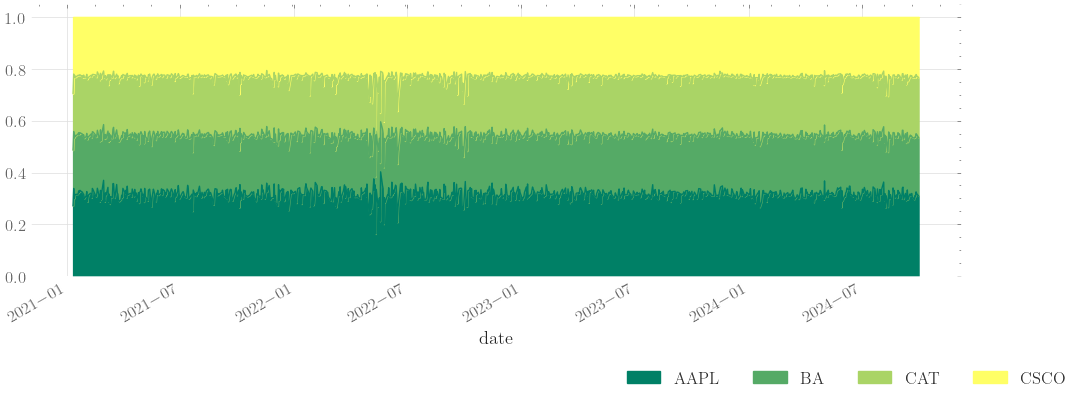

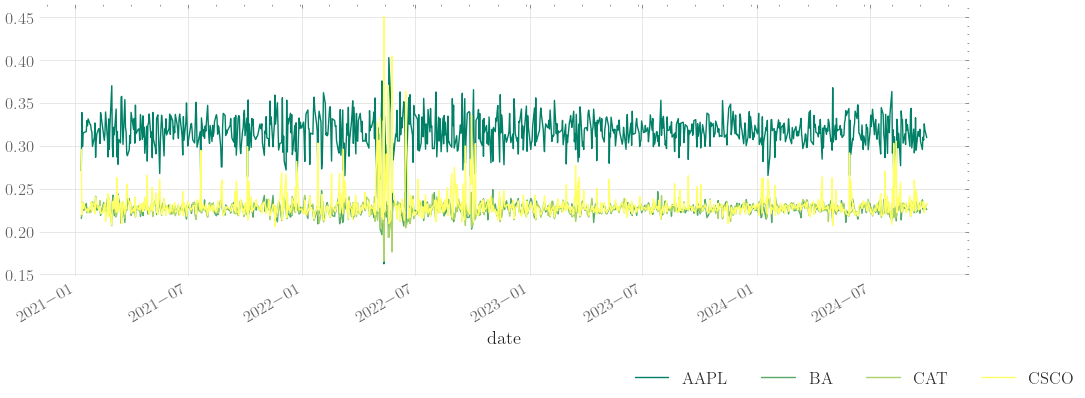

In [19]:
import quantstats as qs
w = pd.DataFrame(result_ppo['test'][0].weights.tolist())
columns = (test_data.tic.unique().tolist())
columns.append('date')
w['date'] = result_ppo['test'][0].date
w.columns = columns
w.iloc[1:,].plot(x='date',figsize=(12,4),kind='area', stacked=True,colormap="summer").legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
w.iloc[1:,].plot(x='date',figsize=(12,4),colormap="summer").legend(ncol=8,bbox_transform=plt.gcf().transFigure, bbox_to_anchor=(1,0))
zz = result_ppo['test'][0]['daily_return']
zz.index=result_ppo['test'][0]['date']
print('max drowdown:', qs.stats.max_drawdown(result_ppo['test'][0].account) , 'Sharp ratio:', qs.stats.sharpe(result_ppo['test'][0].daily_return))
# result_ppo['test'][0].plot(x='date',y='account',figsize=(12,4))